In [1]:
from functools import partial

import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)
 
from innlib.models import DeepConditionalModel
from innlib.training import train_online
from innlib.losses import maximum_likelihood_loss
from innlib.viz import plot_true_est_scatter, plot_true_est_posterior
import innlib.diagnostics as diag

/home/stefan/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
tf.enable_eager_execution()

In [3]:
%load_ext autoreload
%autoreload 2

# Summary network definition 
<p> The summary network is responsible to learn a fixed size representation of the observed data and extract
    maximally informative statistics from the data. </p>

In [43]:
class RecurrentSummaryNetwork(tf.keras.Model):
    def __init__(self, meta):
        super(RecurrentSummaryNetwork, self).__init__()
        
        
        # This model will then run through the concatenated embeddings
        self.lstm = tf.keras.layers.CuDNNLSTM(meta['n_units'], recurrent_initializer='glorot_uniform')
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(meta['n_units'], activation=meta['activation'])
            for i in range(meta['n_dense'])
        ])
        
        if meta['embedding']:
            self.feature_embedding = [tf.keras.layers.Dense(meta['embedding_dim']) 
                                      for _ in range(meta['embedding_layers'])]
        else:
            self.feature_embedding = None
    
    def call(self, x, training=True):
        """
        Performs a forward pass through the summary network
        Arguments:
        x : tf.Tensor of shape (batch_size, n_obs, x_dim) - a batch of samples from p(x|theta)
        """
        
        if self.feature_embedding is not None:
            x = tf.concat([emb(x) for x, emb in zip(x, self.feature_embedding)], axis=-1)
        
        return self.dense(self.lstm(x))
    
    
class ConvSummaryNetwork(tf.keras.Model):
    def __init__(self, meta):
        super(ConvSummaryNetwork, self).__init__()
        
        
        # This model will then run through the concatenated embeddings
        self.conv = tf.keras.Sequential([
            tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation='elu'),
            tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation='elu'),
            tf.keras.layers.Conv1D(128, kernel_size=3, strides=1, activation='elu'),
            tf.keras.layers.Conv1D(128, kernel_size=3, strides=1, activation='elu'),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(meta['n_units'])
        ])
        
        if meta['embedding']:
            self.feature_embedding = [tf.keras.layers.Dense(meta['embedding_dim']) 
                                      for _ in range(meta['embedding_layers'])]
        else:
            self.feature_embedding = None
     
    
    def call(self, x, training=True):
        """
        Performs a forward pass through the summary network
        Arguments:
        x : tf.Tensor of shape (batch_size, n_obs, x_dim) - a batch of samples from p(x|theta)
        """
        
        # Embed if specified
        if self.feature_embedding is not None:
            x = tf.concat([emb(x) for x, emb in zip(x, self.feature_embedding)], axis=-1)
        
        return self.conv(x)

# Forward model priors and generator

In [5]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------
    
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    
    epsilons = np.random.uniform(0, 1, size=batch_size)
    xis = np.random.uniform(0, 1, size=batch_size)
    theta = np.c_[epsilons, xis].astype(np.float32)
    return theta

In [29]:
def Likelihood(s,z,vartheta_par):
    if z == 0:
        s = 1-s
    f = s/sum(s)
    h = vartheta_par*f + (1-vartheta_par)*np.array([1/3,1/3,1/3])
    return h

def Posterior(lik,pre):
    out = (lik*pre)/np.sum(lik*pre)
    return out

def smoothVec(z,s,epsilon_par,lambda_par,xi_par,omega0):
    omega = z*lambda_par*(omega0**epsilon_par)*s + (1-z)*xi_par*(1-(omega0**epsilon_par)*s) + (1 - (z*lambda_par + (1-z)*xi_par))*omega0
    return omega

def TransMat(o):
    G = np.diag(o)
    G[0][G[0]==0] = (1-o[0])/2
    G[1][G[1]==0] = (1-o[1])/2
    G[2][G[2]==0] = (1-o[2])/2
    return G

def ChapmanKolmogorov(G,posterior):
    p = np.inner(posterior,np.transpose(G))
    return p

def MatchingMatrix(n_trials, ambiguity):
    M = np.array([np.random.choice([1,2,3,4],3,replace=ambiguity) for _ in range(n_trials)])
    return M

def forward_model(params, n_obs=None, vartheta_par=.99, max_trials=128, 
                  ambiguity=False, lambda_par=.99, **args):
    """
    Runs the forward model ones, i.e., generates a sample from p(x|theta).
    ----------
    
    Arguments:
    params : np.ndarray of shape (theta_dim, ) -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    # Again, toy
    epsilon_par, xi_par = params
    # Initialize Vectors #
    M = MatchingMatrix(max_trials, ambiguity)
    
    target_rule = np.zeros(max_trials, dtype=int) # Initialize the vector of correct rules
    correct_stimulus_card = np.zeros(max_trials, dtype=int) # Initialize the vector of correct stimulus cards
    x = np.zeros(max_trials, dtype=int) # Initialize the vector of the states (0: set-maintainance, 1: set-shifting)
    y = np.zeros(max_trials, dtype=int) # Initialize the vector of the agent's stimulus cards choice
    z = np.zeros(max_trials, dtype=int) # Initialize the vector of received feedback (1: correct, 0: error)
    s = np.zeros((max_trials,3), dtype=int) # Initialize the signal vector
    omega = np.zeros((max_trials,3)) # Initialize the vector of the attention to reward process
    pre = np.zeros((max_trials,3)) # Initialize the vector of the predictive (prior) probabilities
    lik = np.zeros((max_trials,3)) # Initialize the vector of likelihoods
    post = np.zeros((max_trials,3)) # Initialize the vector of posteriors
    target_rules_vector = np.tile(np.array([1,2,3]),20) # Vector of possible target rules
    
    # First Trial (the first correct response is given as in the standard version of Heaton's WCST) #
    i = 0 # Target rule indicator
    target_rule[0] = target_rules_vector[i] # Actual target rule
    correct_stimulus_card[0] = M[0][target_rule[0]-1] # Correct stimulus card
    pre[0] = np.array([1/3,1/3,1/3])
    x[0] = 2
    y[0] = M[0][x[0]-1] # Select the first correct stimulus card
    z[0] = int(y[0] == correct_stimulus_card[0]) # feedback
    s[0] = y[0] == M[0] # signal
    omega[0] = smoothVec(z[0],s[0],epsilon_par,lambda_par,xi_par,np.array([0.5,0.5,0.5])) # Update omega
    lik[0] = Likelihood(s[0],z[0],vartheta_par)
    post[0] = Posterior(lik[0],pre[0])
    G = TransMat(omega[0])
    
    c = 0 # Initialize the stopping criterion
    for t in range(1,max_trials):
        target_rule[t] = target_rules_vector[i] # Current target rule
        correct_stimulus_card[t] = M[t][target_rule[t]-1] # Current correct stimulus card
        pre[t] = ChapmanKolmogorov(G, post[t-1]) # Compute predictive distribution
        x[t] = np.random.choice([1,2,3],1,p=pre[t]) # Sample the state (feature)
        y[t] = M[t][x[t]-1] # Choose sorting card
        z[t] = int(y[t] == correct_stimulus_card[t]) # feedback
        s[t] = y[t] == M[t] # signal
        omega[t] = smoothVec(z[t],s[t],epsilon_par,lambda_par,xi_par,omega[t-1]) # Update omega
        lik[t] = Likelihood(s[t],z[t],vartheta_par) # Compute Likelihood of the observation given the states
        post[t] = Posterior(lik[t],pre[t]) # Compute posterior distribution over the hidden states
        G = TransMat(omega[t]) # Update Stability Matrix
        
        # Stopping condition (The task ends when the agent collects a series of 6 10 consecutive correct responses)
        if z[t] == 1:
            if z[t] == z[t-1]:
                c = c + 1
            else:
                c = 0
        if c == 9:
            i += 1
            c = 0
            
    return np.c_[z,y,M]

In [44]:
def data_generator(batch_size, n_obs=None, to_categorical=True, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    n_obs      : int -- the numebr of observations to draw from p(x|theta)
    to_tensor  : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from prior
    # theta is a np.array of shape (batch_size, theta_dim)
    theta = prior(batch_size)
    
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    x = np.apply_along_axis(forward_model, axis=1, arr=theta, n_obs=n_obs, **args)
    
    # Convert to a list of one hot encoded-vectors, if specified
    if to_categorical:
        x = [tf.keras.utils.to_categorical(x[:, :, i]) if i !=0 else x[:, :, 0:1] for i in range(x.shape[2])]
    
    # Convert to tensor, if specified 
    if to_tensor:
        theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        if to_categorical:
            x = [tf.convert_to_tensor(x_var, dtype=tf.float32) for x_var in x]
        else:
            x = tf.convert_to_tensor(x, dtype=tf.float32)
    return theta, x

# Training hyperparameters

In [46]:
# Network hyperparameters
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}

n_inv_blocks = 4
                
summary_meta = {
    'n_units': 64,
    'activation': 'elu',
    'n_dense': 2,
    'embedding': True,
    'embedding_dim': 16,
    'embedding_layers': 2
}


# Forward model hyperparameters
param_names = ['epsilon', 'xi']
theta_dim = len(param_names)
n_test = 500


# Training and optimizer hyperparameters
ckpt_file = "final_rnn_embedding_var"
batch_size = 64
epochs = 50
iterations_per_epoch = 1000
n_samples_posterior = 2000
clip_value = 5.

starter_learning_rate = 0.001
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Create data gen and test data

In [47]:
data_gen = partial(data_generator)

In [48]:
theta_test, x_test = data_gen(n_test) 

## Create networks

In [49]:
summary_net = RecurrentSummaryNetwork(summary_meta)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

## Compile 
<p>In other words, run and plot performance of untrained networks.</p>

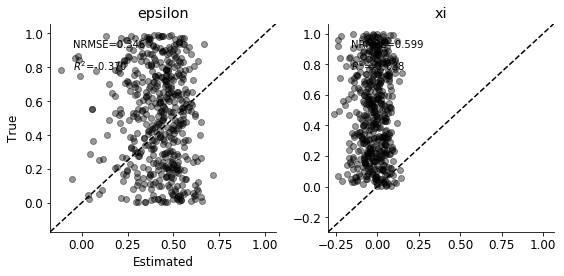

In [50]:
plot_true_est_scatter(model, x_test, theta_test, n_samples_posterior, param_names, figsize=(8, 4))

## Manage checkpoints

In [51]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


# Train networks

Instructions for updating:
Use tf.cast instead.


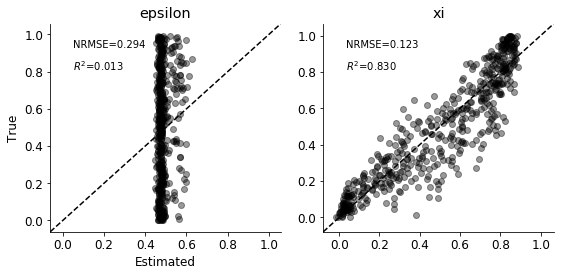

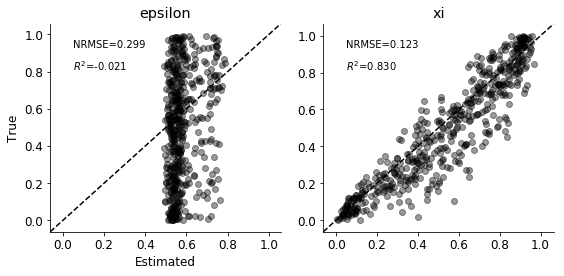

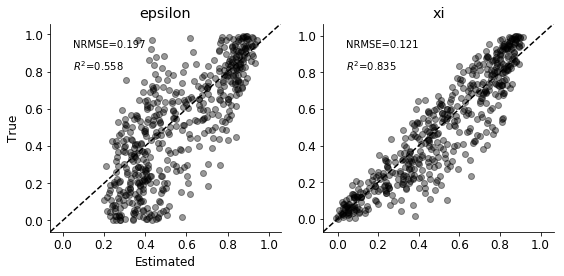

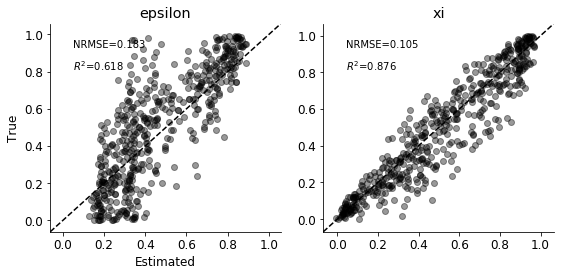

Instructions for updating:
Use standard file APIs to delete files with this prefix.



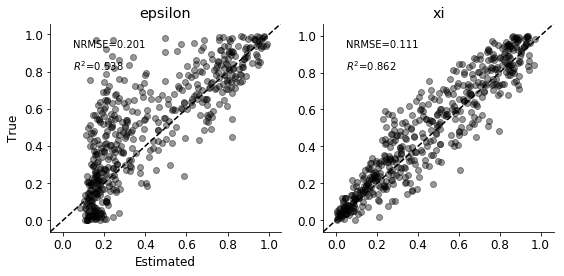

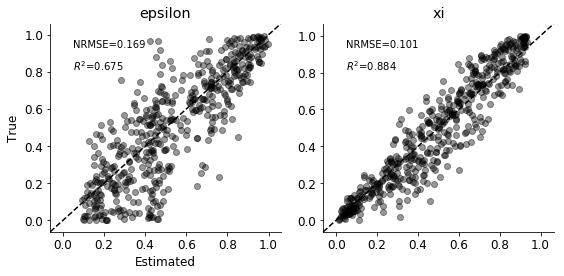

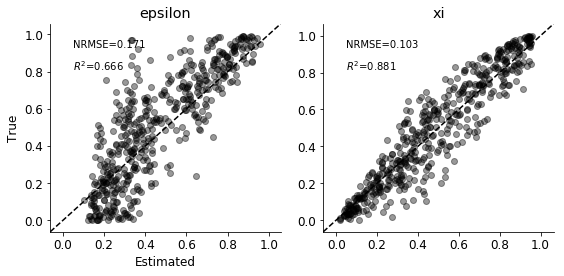

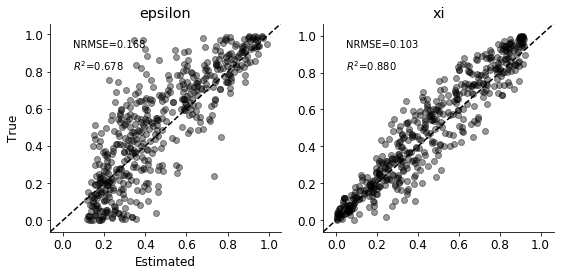

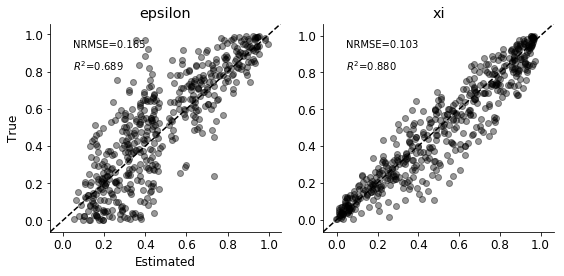

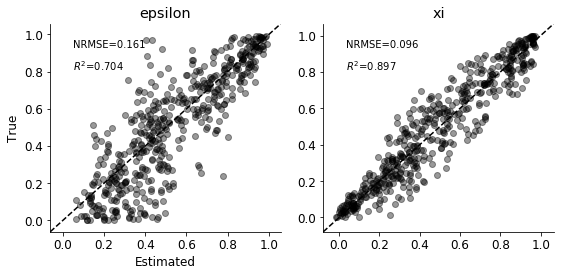

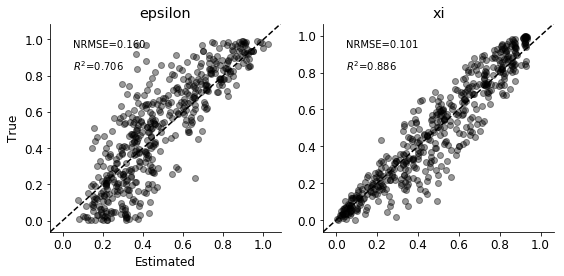

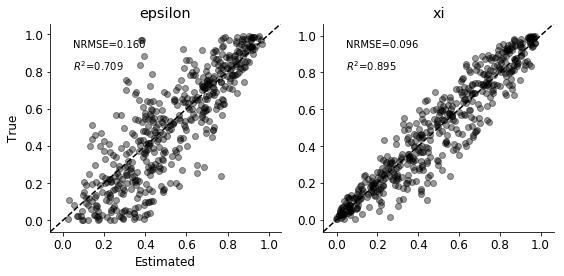

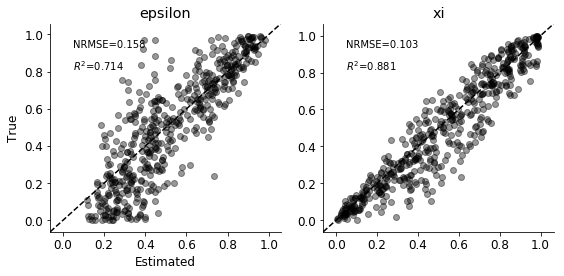

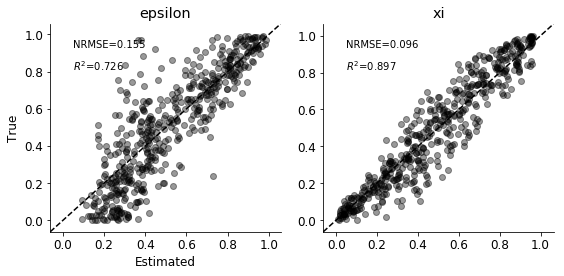

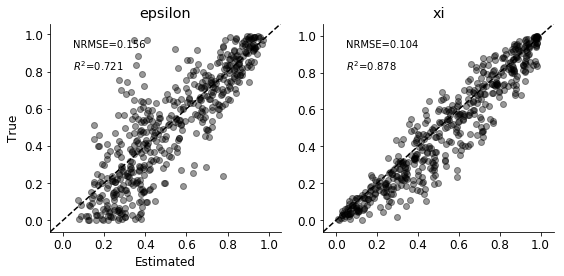

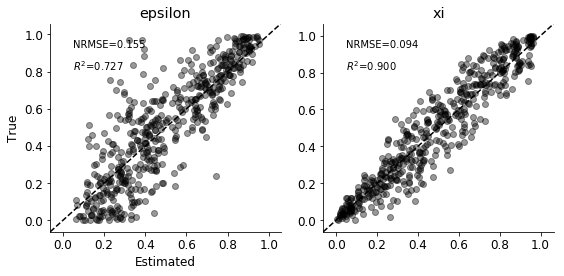

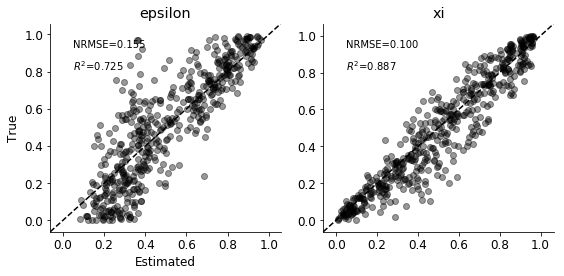

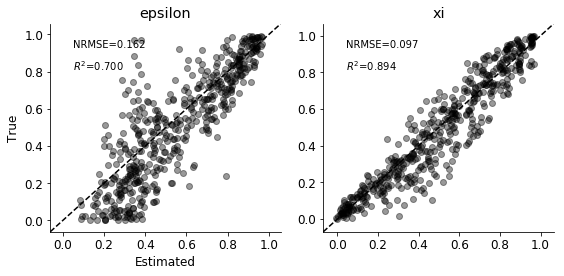

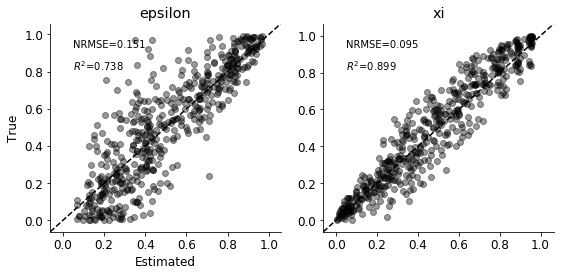

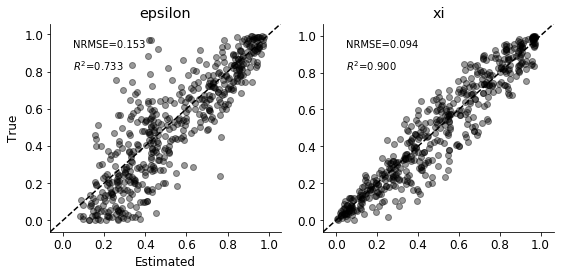

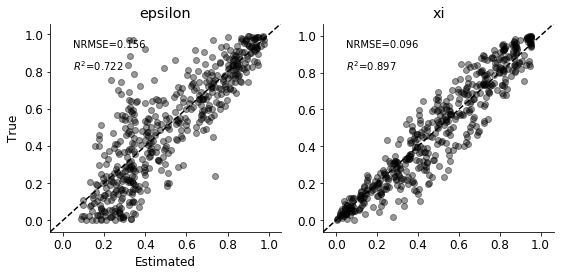

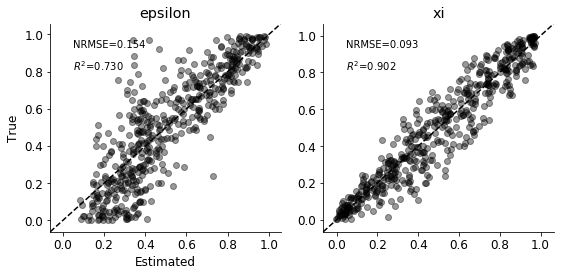

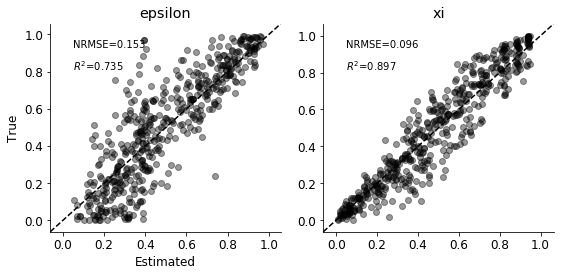

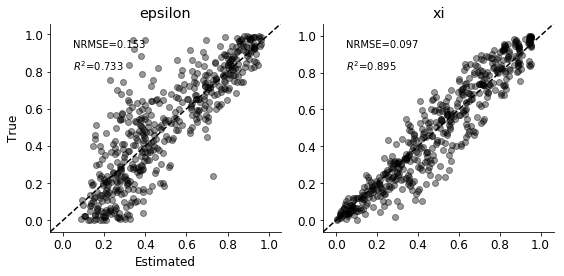

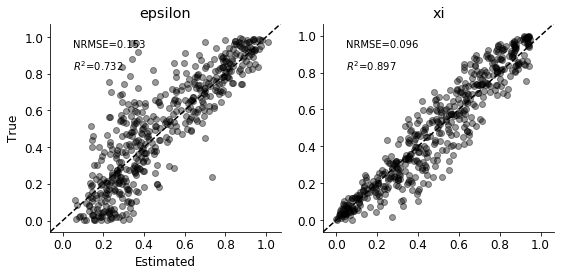

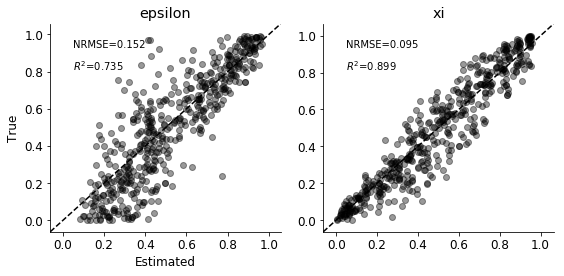

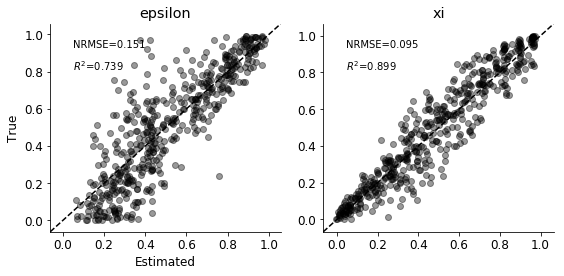

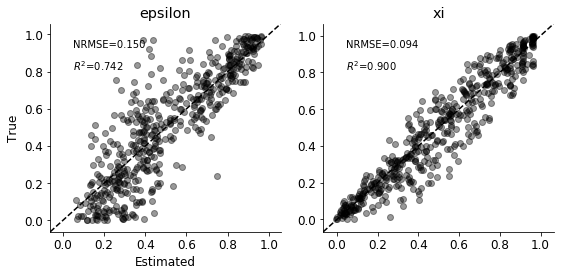

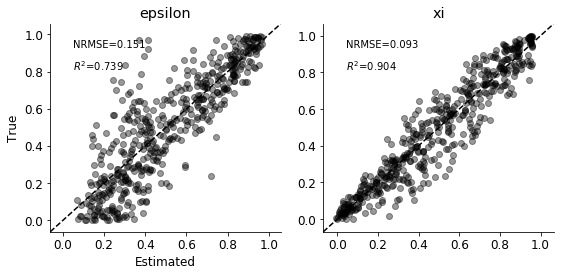

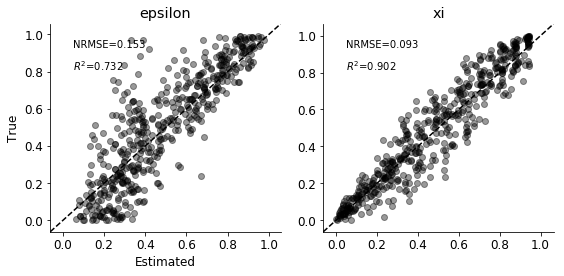

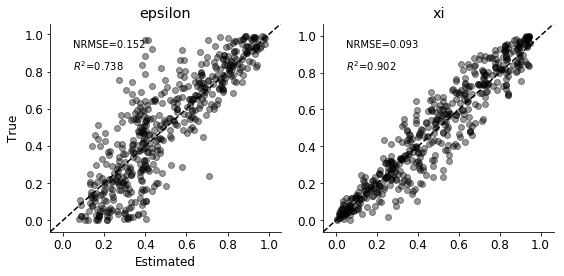

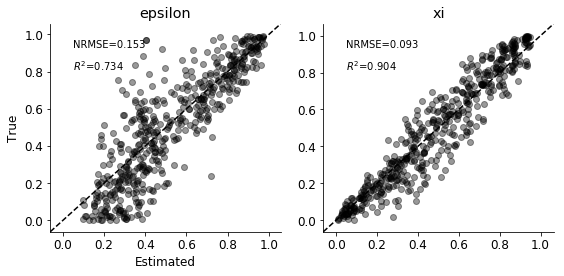

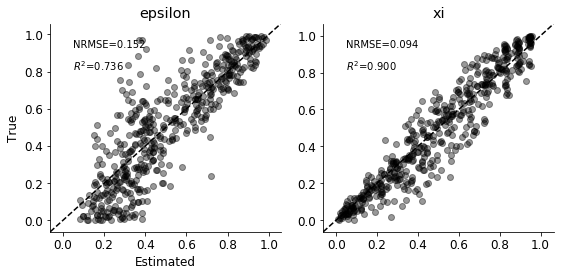

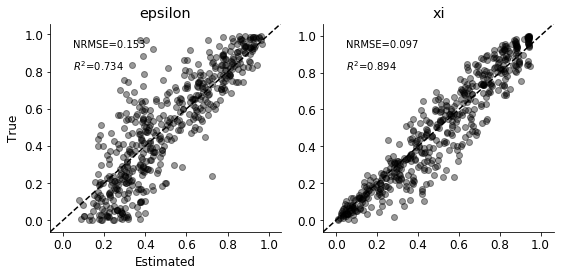

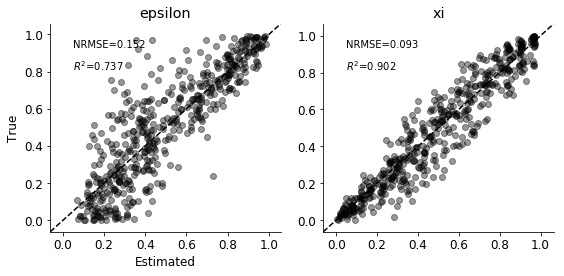

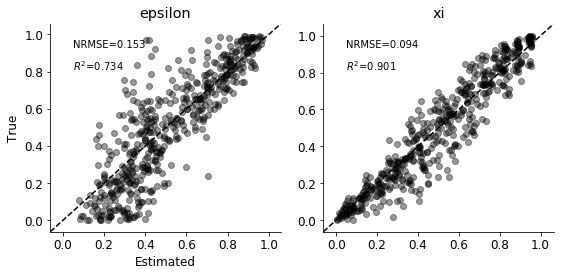

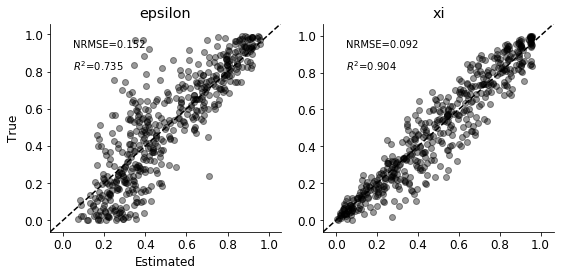

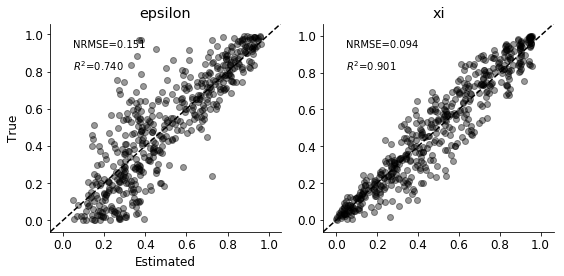

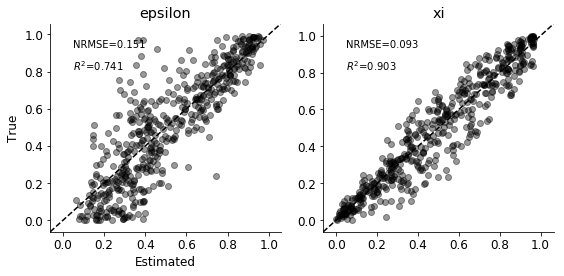

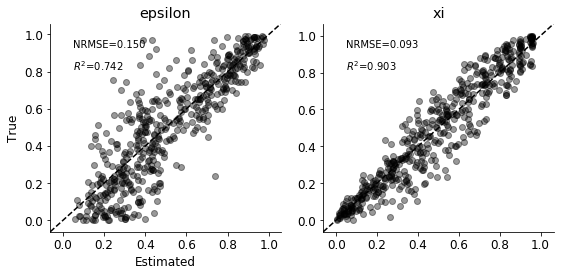

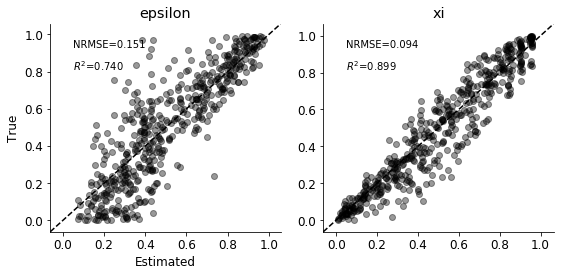

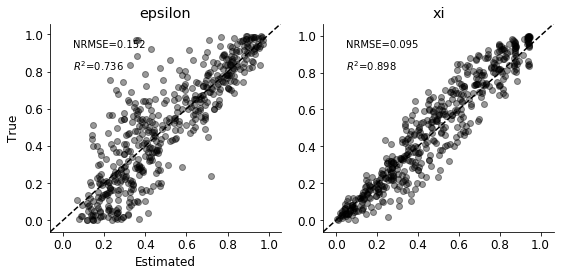

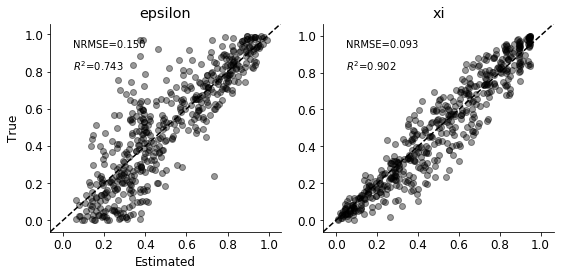

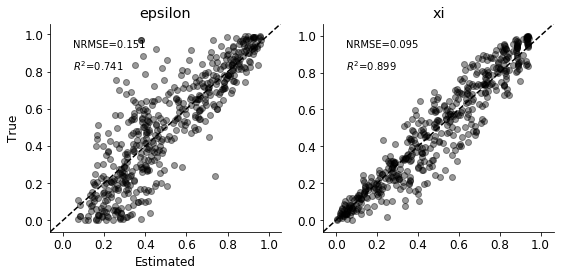

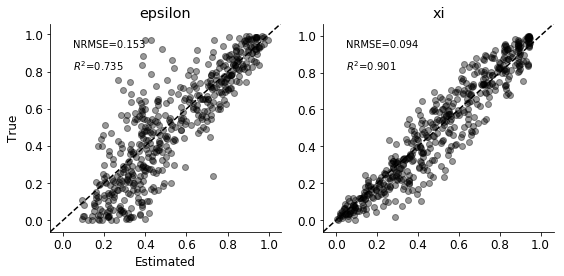

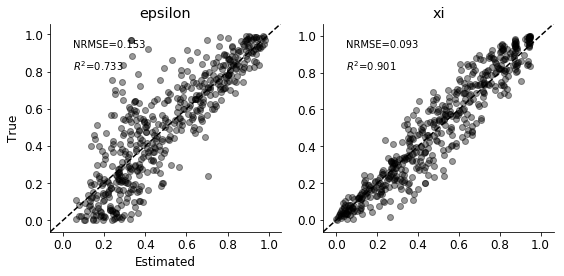

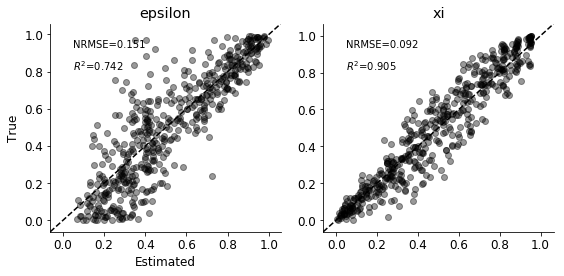

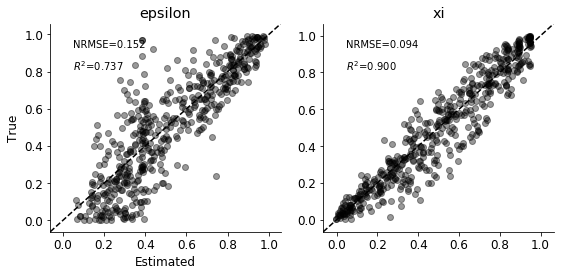

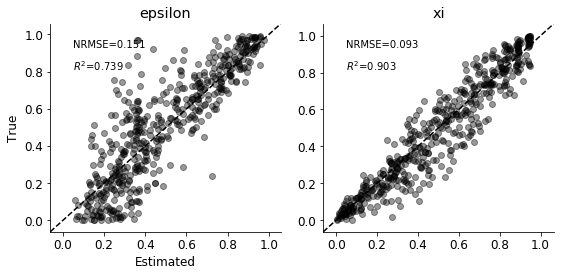

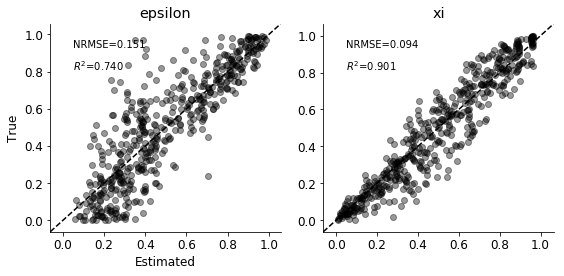

In [52]:
# %%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=maximum_likelihood_loss, 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              clip_value=clip_value,
                              global_step=global_step)
        
        plot_true_est_scatter(model, x_test, theta_test, n_samples_posterior, param_names, figsize=(8, 4))
        manager.save()

# Test performance

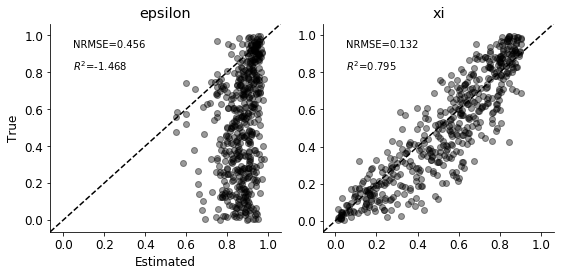

In [28]:
plot_true_est_scatter(model, x_test, theta_test, n_samples_posterior, param_names, figsize=(8, 4))